## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [43]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob

# LDA 
from sklearn.decomposition import LatentDirichletAllocation

# for classification 
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

#set seed
import random
random.seed(10)


In [2]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
congress_tweets = congress_tweets.sample(10000).reset_index(drop = True) #I added ".reset_index to start everything at 0"
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.267820e+18,RepKClark,2020-06-02T10:21:07-04:00,"Yesterday, #MA announced that #childcare could...",Katherine Clark,Rep,12-Dec-13,7/17/1963,F,MA,5,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314"
1,1.229840e+18,RepBarbaraLee,2020-02-18T13:41:00-05:00,We’re on the verge of an #AIDS free generation...,Barbara Lee,Rep,21-Apr-98,7/16/1946,F,CA,13,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.188110e+18,RepJohnLarson,2019-10-26T11:00:01-04:00,Requiring background checks for gun buyers is ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892"
3,1.191460e+18,RepDebDingell,2019-11-04T15:48:17-05:00,My colleagues and I are working on legislation...,Debbie Dingell,Rep,3-Jan-15,11/23/1953,F,MI,12,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256"
4,1.116070e+18,RepDwightEvans,2019-04-10T15:56:44-04:00,RT @RepDwightEvans Thanks to @Philasunnews for...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [3]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words.add("today")
    nlp.Defaults.stop_words.add("amp")
    nlp.Defaults.stop_words.add("rt")
    nlp.Defaults.stop_words.add("qt")
    nlp.Defaults.stop_words.add("need")
    nlp.Defaults.stop_words.add("\n\n")
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [token.text.lower() for token in doc] #I added this to get everything in lowercase
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [4]:
#Making sure the text column doesn't have NAs
congress_tweets = congress_tweets.dropna(subset = ['text'])

#Using the function above to tokenize
congress_tweets['tokens']= congress_tweets['text'].map(lambda x: rem_punc_stop(x))

In [5]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,1.267820e+18,RepKClark,2020-06-02T10:21:07-04:00,"Yesterday, #MA announced that #childcare could...",Katherine Clark,Rep,12-Dec-13,7/17/1963,F,MA,5,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314","[yesterday, ma, announced, childcare, reopen, ..."
1,1.229840e+18,RepBarbaraLee,2020-02-18T13:41:00-05:00,We’re on the verge of an #AIDS free generation...,Barbara Lee,Rep,21-Apr-98,7/16/1946,F,CA,13,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[verge, aids, free, generation, –, invest, pro..."
2,1.188110e+18,RepJohnLarson,2019-10-26T11:00:01-04:00,Requiring background checks for gun buyers is ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892","[requiring, background, checks, gun, buyers, c..."
3,1.191460e+18,RepDebDingell,2019-11-04T15:48:17-05:00,My colleagues and I are working on legislation...,Debbie Dingell,Rep,3-Jan-15,11/23/1953,F,MI,12,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256","[colleagues, working, legislation, set, ambiti..."
4,1.116070e+18,RepDwightEvans,2019-04-10T15:56:44-04:00,RT @RepDwightEvans Thanks to @Philasunnews for...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434","[repdwightevans, thanks, philasunnews, coverin..."


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1 : Word Cloud

In [6]:
#Use word cloud to visualize most frequent words used dependeing on party affiliation or position
dem=congress_tweets[congress_tweets["party"]=="Democrat"]
rep=congress_tweets[congress_tweets["party"]=="Republican"]
congress=congress_tweets[congress_tweets["position"]=="Rep"]
senate=congress_tweets[congress_tweets["position"]=="Sen"]

In [7]:
def wordcloud(dat):
    
    text = dat["tokens"]
     #Convert the list of tokens into a string and put a space between tokens
    text = ' '.join(text.map(lambda text: ' '.join(text)))

    #Feed string to worldcloud: use the generate method to create a worldcloud object
    wordcloud = WordCloud().generate(text)

    #Plot
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.show()   

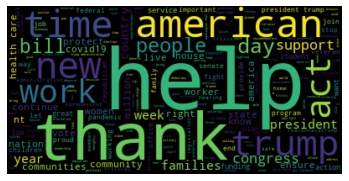

In [8]:
#Democratic reps
wordcloud(dem)

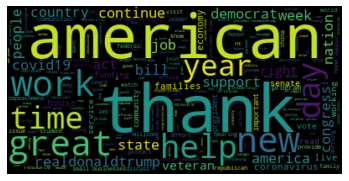

In [9]:
#Republican reps
wordcloud(rep)

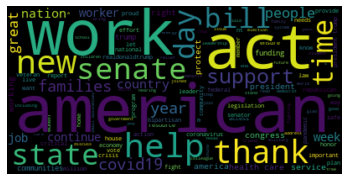

In [10]:
#Senators reps
wordcloud(senate)

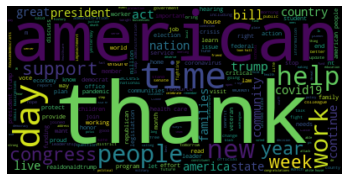

In [11]:
#Congresspeople reps
wordcloud(congress)

### EDA 2: Topic Modeling

In [12]:
#define function to print topics 
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [13]:
# loop through each of the five categories and create five topic models for each
cats = [congress_tweets, dem, rep, senate, congress]
names = ["All tweets", "Democrats", "Republicans", "Senate", "House"]
all_topics = [] 
for c,n in zip(cats,names): 
    X = c["text"]
    tf = TfidfVectorizer(tokenizer = rem_punc_stop)
    tfidf_matrix =  tf.fit_transform(X)
    dense_matrix = tfidf_matrix.todense()
    lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
    lda = lda.fit(dense_matrix)
    tf_feature_names = tf.get_feature_names()
    print("The topics for " + n + " are: ")
    print_top_words(lda, tf_feature_names, 20)
    topic_dist = lda.transform(tfidf_matrix) 
    topic_dist_df = pd.DataFrame(topic_dist).reset_index(drop = True)
    all_topics.append(topic_dist_df)

The topics for All tweets are: 

Topic #0:

   trump people president health act house help work covid19 time americans american congress thank new bill care —

Topic #1:
miners wyoming jose preparedness nextrevfnc tune baseball nominees hesitate pensions cicilline workshops fun ribbon eidl nasa breonna 🚀 neighbor library

Topic #2:
de polling mi lights polls en y loophole mikepence chag sameach el la passover que napa nationalvoterregistrationday church charleston los

Topic #3:
lewis newsletter amy pfas coney weekly 🔥 harbor irsnews complaint nomination mobile repcummings separation hanukkah pearl barrett ginsburg experienced submitted

Topic #4:
de inquiry la el en que y los para netneutrality savethenet houseintel bolton lowerdrugcosts 👀 sondland hunter syria harris arizonans

The topics for Democrats are: 

Topic #0:

 trump   health act people president house help covid19 time work care americans congress new — bill families thank

Topic #1:
fill meals wishing thanksgiving ocean 

In [14]:
all_topics

[             0         1         2         3         4
 0     0.862971  0.034257  0.034257  0.034259  0.034256
 1     0.860400  0.034881  0.034961  0.034879  0.034879
 2     0.841843  0.039540  0.039540  0.039539  0.039539
 3     0.751411  0.043040  0.043020  0.043017  0.119512
 4     0.815817  0.045908  0.045907  0.045916  0.046452
 ...        ...       ...       ...       ...       ...
 9995  0.556859  0.034437  0.034367  0.340106  0.034231
 9996  0.862530  0.034368  0.034368  0.034368  0.034367
 9997  0.852941  0.036765  0.036765  0.036764  0.036764
 9998  0.804735  0.048817  0.048817  0.048816  0.048816
 9999  0.693427  0.034233  0.034233  0.034256  0.203850
 
 [10000 rows x 5 columns],
              0         1         2         3         4
 0     0.863127  0.034195  0.034290  0.034193  0.034195
 1     0.852992  0.034921  0.042239  0.034926  0.034922
 2     0.841938  0.039513  0.039513  0.039522  0.039514
 3     0.828147  0.042959  0.042959  0.042974  0.042962
 4     0.481813  0.

#### Examining the topics

*ALL TWEETS*: First, we created five topics based on the entire corpus of tweets to see if there are any apparent Democrat or Republican topics. Topic #1 seems to cover climate change and DACA, which are Democratic causes, but also contains less cut-and-dry terms about Venezuela PM Nicolas Maduro and Rudy Giuliani. Overall, there do not seem to be any useful topics based on the entire body of congressional tweets. 

*DEMOCRATS*: Among the topics created based on democrats' tweets, Topics #0 and #4 seem to be the most useful. Democrats may be more likely to tweet in Spanish as in #0, but the terms appear to be stopwords in Spanish. Topic #4 covers DACA and funding the post office. While together not necessarily a coherent topic, both have been major Democratic issues. 

*REPUBLICANS*: Unlike we might have expected, there do not appear to be any clear Make America Great Again topics. 

*SENATE*: The Senate terms seem to refer to the Senate, Amy Coney Barrett's confirmation process, veterans, and bills. The clusters of topics do not seem to be especially distinct from one another.  

*HOUSE*: As with the Senate, these topics do not seem to be especially coherent either. Gerrymandering comes up as a term which makes sense for the House, but the topic does not appear to be about gerrymandering.


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

### 1. Compare 2 senators:

In [15]:
bernie_sanders = congress_tweets[congress_tweets["name_wikipedia"]=="Bernie Sanders"]
Nancy_Pelosi = congress_tweets[congress_tweets["name_wikipedia"]=="Nancy Pelosi"]
mitch_mcconnell = congress_tweets[congress_tweets["name_wikipedia"]=="Mitch McConnell"]

In [16]:
def sentiment(legislator):
    legislator.loc[:,'tokens']= legislator.loc[:,'tokens'].map(lambda text: ' '.join(text))
    legislator.loc[:,'polarity']= legislator.loc[:,'tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
    legislator.loc[:,'subjectivity']= legislator.loc[:,'tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
    return(legislator)

def threeplots(dat):
    fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
    sns.histplot(dat, x="polarity", ax=ax1)
    sns.histplot(dat, x="subjectivity", ax=ax2)
    sns.barplot(x=dat.subjectivity.round(2), y = 'polarity', data=dat, ax=ax3)
    return fig

In [17]:
bernie_sanders=sentiment(bernie_sanders)
Nancy_Pelosi=sentiment(Nancy_Pelosi)
mitch_mcconnell=sentiment(mitch_mcconnell)
dem_sentiment=sentiment(dem)
rep_sentiment=sentiment(rep)
senate_sentiment=sentiment(senate)
congress_sentiment=sentiment(congress)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


#### Bernie Sanders

<ipython-input-18-0ebfee07b780>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(bernie_sanders).show()


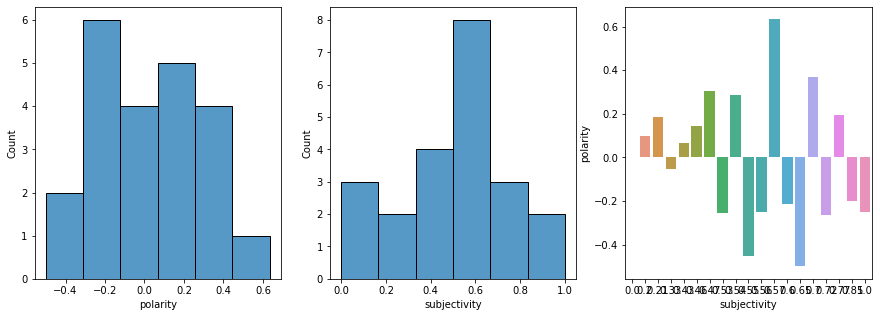

In [18]:
threeplots(bernie_sanders).show()

#### Mitch McConnell

<ipython-input-19-b68bcc6f07ff>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(mitch_mcconnell).show()


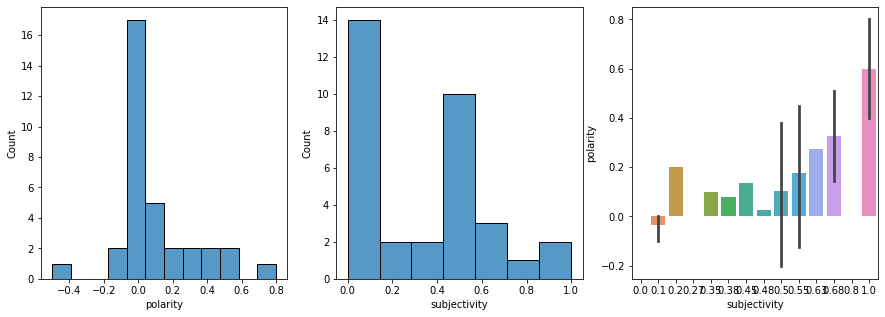

In [19]:
threeplots(mitch_mcconnell).show()

### 2. compare Democrats vs. Republicans 

#### Democrats

<ipython-input-20-1946d568614e>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(dem_sentiment).show()


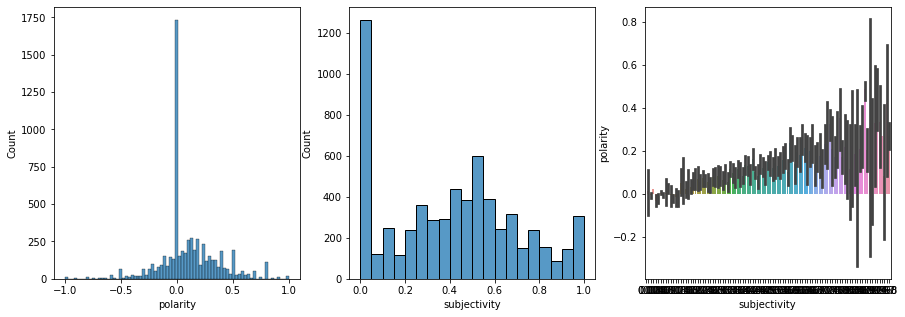

In [20]:
threeplots(dem_sentiment).show()

#### Republicans

<ipython-input-21-2b8d585f0767>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(rep_sentiment).show()


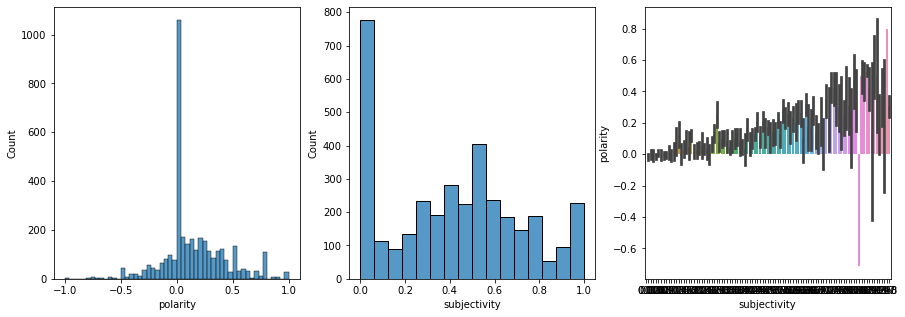

In [21]:
threeplots(rep_sentiment).show()

### 3. Compare Senators to Congresspeople

#### Senators

<ipython-input-22-91a0348dd227>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(senate_sentiment).show()


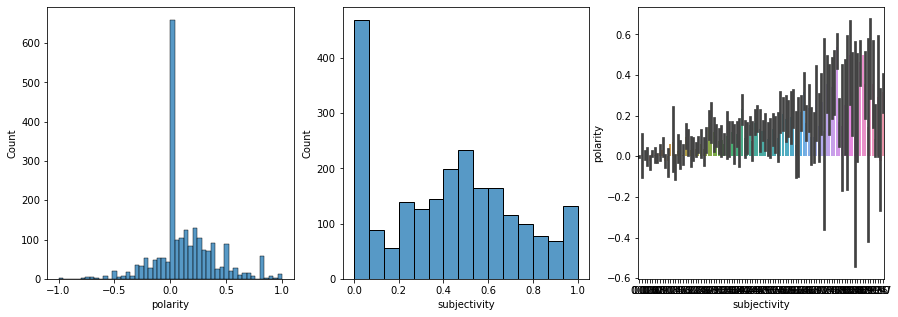

In [22]:
threeplots(senate_sentiment).show()

#### Congresspeople

<ipython-input-23-4eb25a0f8ba8>:1: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  threeplots(congress_sentiment).show()


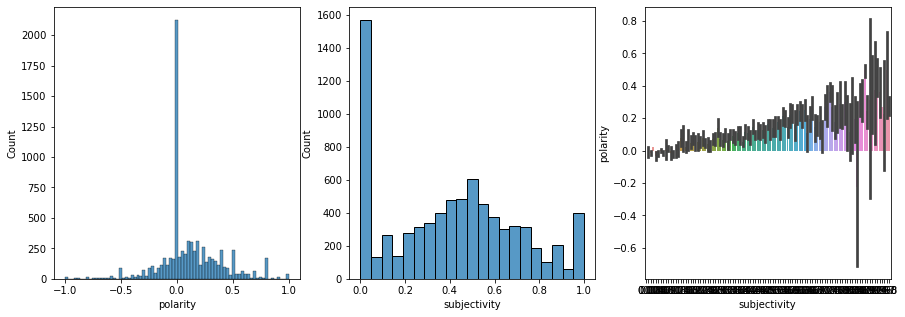

In [23]:
threeplots(congress_sentiment).show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

In [24]:
#I had to make another column for 'tokens_string' so the polarity and subjectivity features would work as well as TF-idf. 
#The embedding-based featurization uses the original 'tokens'
#I don't really understand why this is so maybe this is something we can discuss
congress_tweets['tokens_string'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['polarity'] = congress_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens_string'].map(lambda text: TextBlob(text).sentiment.subjectivity)

In [25]:
congress_tweets.columns

Index(['tweet_id', 'screen_name', 'datetime', 'text', 'name_wikipedia',
       'position', 'joined_congress_date', 'birthday', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share', 'tokens', 'tokens_string', 'polarity',
       'subjectivity'],
      dtype='object')

In [26]:
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_string,polarity,subjectivity
0,1.267820e+18,RepKClark,2020-06-02T10:21:07-04:00,"Yesterday, #MA announced that #childcare could...",Katherine Clark,Rep,12-Dec-13,7/17/1963,F,MA,5,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314","[yesterday, ma, announced, childcare, reopen, ...",yesterday ma announced childcare reopen phase ...,0.000000,0.000
1,1.229840e+18,RepBarbaraLee,2020-02-18T13:41:00-05:00,We’re on the verge of an #AIDS free generation...,Barbara Lee,Rep,21-Apr-98,7/16/1946,F,CA,13,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958","[verge, aids, free, generation, –, invest, pro...",verge aids free generation – invest programs k...,0.200000,0.900
2,1.188110e+18,RepJohnLarson,2019-10-26T11:00:01-04:00,Requiring background checks for gun buyers is ...,John B. Larson,Rep,3-Jan-99,7/22/1948,M,CT,1,Democrat,"673,215","897,572","905,083","634,892","[requiring, background, checks, gun, buyers, c...",requiring background checks gun buyers compreh...,-0.500000,0.900
3,1.191460e+18,RepDebDingell,2019-11-04T15:48:17-05:00,My colleagues and I are working on legislation...,Debbie Dingell,Rep,3-Jan-15,11/23/1953,F,MI,12,Democrat,"2,279,543","2,268,839","2,564,569","2,115,256","[colleagues, working, legislation, set, ambiti...",colleagues working legislation set ambitious g...,0.308333,0.725
4,1.116070e+18,RepDwightEvans,2019-04-10T15:56:44-04:00,RT @RepDwightEvans Thanks to @Philasunnews for...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434","[repdwightevans, thanks, philasunnews, coverin...",repdwightevans thanks philasunnews covering fe...,0.050000,0.150


### Engineered Text Features

In [27]:
# Engineered Features, I think we only did polarity and subjectivity during EDA but can add in the other EDA feature Kelly does later
engineered_features = congress_tweets[['polarity', 'subjectivity']].reset_index(drop = True)

In [28]:
engineered_features.head()

,polarity,subjectivity
0,0.000000,0.000
1,0.200000,0.900
2,-0.500000,0.900
3,0.308333,0.725
4,0.050000,0.150


### Bag-of-words or Tf-idf

In [29]:
# Frequency Based featurization (TF-idf)
X = congress_tweets['tokens_string'] #I'm not sure if I'm supposed to use 'text' or 'tokens' here because doesn't the next line tokenize for us? I may be completely misunderstanding lol
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

#Choose top tokens used across docs

In [30]:
tfidf_df.head()

,\n,\n\n\n,\n\n,\n\n,\n\n,\n,\n \n,\n \n\n \n,\n \n,\n \n \n,...,🦴,🦷,🧁,🧑,🧡,🧢,🧰,🧼,🧽,🩺
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [31]:
model = gensim.models.Word2Vec(congress_tweets['tokens'], size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

In [32]:
#just wanted to test out what the output from the model looks like
model['american']

<ipython-input-32-be15e3d15016>:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model['american']


array([ 0.24156831, -0.16508026,  0.13371097,  0.0893788 ,  0.204164  ,
       -0.48571622,  0.44211897,  0.10368139,  0.5098743 ,  0.28619984,
        0.5108508 ,  0.07910433,  0.6757977 ,  0.3830239 ,  0.20345563,
        0.32910645, -0.1746813 , -0.5775112 , -0.33017933, -0.33028406,
        0.30438697, -1.0363685 ,  0.04137645, -0.03680549, -0.04887185,
       -0.33383793, -0.3734271 ,  0.26621234,  0.20091768,  0.21003133,
        0.14358631, -0.27699798,  0.4309216 , -0.17886966,  0.44473323,
        0.03252613,  0.06919468,  0.24020292, -0.46568325,  0.2177787 ,
        0.00302484, -0.13759068, -0.40829977, -0.7609285 ,  0.8388254 ,
        0.09223617,  0.27339667,  0.33037364, -0.3534173 ,  0.63791835,
        0.64735943,  0.12657878,  0.10525218,  0.15543804,  0.57312155,
       -0.3225861 , -1.0948275 ,  0.46039882, -0.3303839 , -0.24160652,
       -0.38908693, -0.18414596,  0.31893227,  0.08025107,  0.18487221,
        0.01060962,  0.17262502,  0.7723574 ,  0.11892769,  0.05

In [33]:
#also just wanted to see what the first 100 words are in our vocabulary
words = list(model.wv.vocab)
print(words[0:100])

['yesterday', 'ma', 'announced', 'childcare', 'reopen', 'phase', '2', 'laying', 'number', 'requirements', 'met', 'developing', 'daily', 'cleaning', 'plans', 'classrooms', 'reducing', 'classroom', 'problem', 'providers', 'struggling', 'financially', 'aids', 'free', 'generation', '–', 'invest', 'programs', 'know', 'work', 'increase', 'access', 'care', 'especially', 'atrisk', 'communities', 'truly', 'want', 'reject', 'trump', 'harmful', 'budget', 'cuts', 'trumpbudget', 'requiring', 'background', 'checks', 'gun', 'comprehensive', 'guns', 'wrong', 'hands', 'senatemajldr', 'refuses', 'allow', 'vote', 'hr8', 'dosomething', 'endgunviolence', 'colleagues', 'working', 'legislation', 'set', 'ambitious', 'goal', 'introduction', 'details', '100', 'clean', 'economy', 'act', 'coming', 'soon', 'repdwightevans', 'thanks', 'covering', 'federal', 'funding', 'announcement', 'community', 'announces', 'grant', 'center', 'staff', 'honored', 'participate', 'beautiful', 'memorial', 'neverforget', 'living', 'un

In [34]:
#I'm not sure how useful (and how much more work) it will be to add the model from Google, so I skipped this step since it's optional. :) 

# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#google_model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [35]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [36]:
# embedding based featurization

#THIS IS WHERE I'M STUCK! If I used 'congress_tweets['tokens'], I keep getting an error about missing an array to concatenate.
#But if I use 'congress_tweets['text']' the code runs and spits out an array. I DON'T GET IT! 

# Initialize an array for the size of the corpus
empty_list_embeddings_means = []
for doc in congress_tweets['tokens']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, doc))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

ValueError: need at least one array to concatenate

In [ ]:
doc_average_embeddings

In [ ]:
word2vec_features_df = pd.DataFrame(doc_average_embeddings)

In [ ]:
word2vec_features_df

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [44]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

dataframes = [engineered_features] 
           #   tfidf_df,
           #   word2vec_features_df]

featurization_technique = ['Engineered Features']
                          # , 'Tf-idf Features', 'Word2Vec Features']

targets = [congress_tweets['party'], congress_tweets['position']]

lb_style = LabelBinarizer()

for df, ft in zip(dataframes,featurization_technique): 
    for t in targets:
        y = t = lb_style.fit_transform(t) 
        
        X_train, X_test, y_train, y_test = train_test_split(df, 
                                                            y, 
                                                            train_size = .80, 
                                                            test_size=0.20, 
                                                            random_state = 10)
        # create a model
        logit_reg = LogisticRegression()

        # fit the model
        logit_model = logit_reg.fit(X_train, y_train.ravel())

        y_pred = logit_model.predict(X_test)
    
        cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

        df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

       # df_cm = df_cm.rename(index=str, columns={0: "Senate", 1: "Student loan"})
       # df_cm.index = ["Checking or savings account", "Student loan"]
        plt.figure(figsize = (10,7))
        sns.set(font_scale=1.4)#for label size
        sns.heatmap(df_cm, 
                   annot=True,
                   annot_kws={"size": 16},
                   fmt='g')

        plt.title(ft)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()
    

ValueError: Found input variables with inconsistent numbers of samples: [8000, 24000]

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# Non-text features
non_text_features = congress_tweets[['position', 'joined_congress_date', 'gender', 'state',
       'district_number', 'party', 'trump_2016_state_share',
       'clinton_2016_state_share', 'obama_2012_state_share',
       'romney_2012_state_share']]
non_text_features['age'] = congress_tweets['datetime'] - congress_tweets['birthday'] 

non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(engineered_features_with_topics)

# Non-text features + tfidf
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
non_text_plus_tfidf = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

# Top 25 ngrams + non-text
non_text_with_ngrams = non_text_features_dummies.reset_index(drop = True).join(top_25_ngrams)

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**